In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np

## Creating VR and VHist Functions 

In [2]:
# https://www.wataugacounty.org/App_Pages/Dept/BOE/precincts.aspx#2

def vr_import_clean(df, cols):
    file = f'{df}'
    
    # Import file into python
    df = pd.read_csv(
    file,
    usecols = cols,
    delimiter = "\t",        
    encoding = "utf-16",  
   # dtype = {'precinct_desc': str}
    )
    # Filter data to just eligible voters
    df['status_cd'] = df['status_cd'].str.strip()

    df = df[(df['status_cd'] == 'A') | (df['status_cd'] == 'I') | (df['status_cd'] == 'S')]
    
    # Remove troublesome data rows and set the 'registr_dt' column as the index
    df = df[df['registr_dt'] != '##/##/####']
    df['registr_dt'] = pd.to_datetime(df['registr_dt'], errors='coerce')
    df = df.set_index('registr_dt')
    
    # Sort data from oldest VR's to newest
    df = df.sort_index(ascending=True)

    return df
    
def vhist_import_clean(df, cols):
    file = f'{df}'
    
    # Import file into python
    df = pd.read_csv(
    file,
    delimiter = "\t",        
    usecols = cols,
    encoding = "latin-1",  
    )
    
    return df

In [3]:
# NC VR file upload

file = 'ncvoter_Statewide.txt'

nc_vr_df = pd.read_csv(
    file,
    delimiter = "\t",        
    usecols = ['registr_dt', 'status_cd'],
    encoding="latin-1",  
)

nc_vr_df = nc_vr_df[(nc_vr_df['status_cd'] == 'A') | (nc_vr_df['status_cd'] == 'I') | (nc_vr_df['status_cd'] == 'T')]

nc_vr_df = nc_vr_df[nc_vr_df['registr_dt'] != '##/##/####']
nc_vr_df['registr_dt'] = pd.to_datetime(nc_vr_df['registr_dt'])
nc_vr_df = nc_vr_df.set_index('registr_dt')

nc_vr_df_asc = nc_vr_df.sort_index(ascending=True)

In [4]:
# NC voter history file upload

file = 'ncvhis_Statewide.txt'

nc_hist_df = pd.read_csv(
    file,
    delimiter = "\t",        
    usecols = ['voted_county_id', 'voter_reg_num', 'county_desc', 'election_lbl'],
    encoding="latin-1",  
)

nc_hist_df.head()

,county_desc,voter_reg_num,election_lbl,voted_county_id
0,GUILFORD,305398,10/10/2017,41
1,GUILFORD,305398,05/08/2018,41
2,GUILFORD,305398,03/05/2024,41
3,GUILFORD,305398,11/07/2017,41
4,GUILFORD,305398,07/26/2022,41


In [5]:
vr_11_20_df = 'VR_Snapshot_20201103.txt'
vr_11_22_df = 'VR_Snapshot_20221108.txt'
vr_11_24_df = 'VR_Snapshot_20241105.txt'

vr_cols = ['registr_dt', 'precinct_abbrv', 'status_cd']

In [6]:
vr_11_20_df = vr_import_clean(vr_11_20_df, vr_cols)
vr_11_22_df = vr_import_clean(vr_11_22_df, vr_cols)
vr_11_24_df = vr_import_clean(vr_11_24_df, vr_cols)

vr_11_24_df.head()

,status_cd,precinct_abbrv
registr_dt,,
1940-05-08,I,MM
1940-05-09,I,PEAC
1940-05-17,I,WADES
1940-10-26,A,06W
1943-08-20,I,707


In [7]:
vhist_11_20_df = 'history_stats_20201103.txt'
vhist_11_22_df = 'history_stats_20221108.txt'
vhist_11_24_df = 'history_stats_20241105.txt'

vhist_cols = ['election_date', 'total_voters']

vhist_11_20_df = vhist_import_clean(vhist_11_20_df, vhist_cols)
vhist_11_22_df = vhist_import_clean(vhist_11_22_df, vhist_cols)
vhist_11_24_df = vhist_import_clean(vhist_11_24_df, vhist_cols)


In [8]:
data = {
    'val_vr': [7359798, 7412050, 7763502],
    'val_vhist': [5545848, 3790202, 5723987],
    'NC_vr': [len(nc_vr_df_asc.loc[:'2020-11-05']), len(nc_vr_df_asc.loc[:'2022-11-08']), len(nc_vr_df_asc.loc[:'2024-11-03'])],
    'NC_vhist': [len(nc_hist_df[nc_hist_df['election_lbl'] == '11/03/2020']), len(nc_hist_df[nc_hist_df['election_lbl'] == '11/08/2022']), len(nc_hist_df[nc_hist_df['election_lbl'] == '11/05/2024'])],
    'snap_vr': [len(vr_11_20_df), len(vr_11_22_df), len(vr_11_24_df)],
    'snap_vhist': [vhist_11_20_df['total_voters'].sum(), vhist_11_22_df['total_voters'].sum(), vhist_11_24_df['total_voters'].sum()]
}

row_labels = ['2020 election', '2022 election', '2024 election']

data_val_df = pd.DataFrame(data, index = row_labels)
data_val_df

,val_vr,val_vhist,NC_vr,NC_vhist,snap_vr,snap_vhist
2020 election,7359798,5545848,5165267,5536901,7378587,5544018
2022 election,7412050,3790202,5947460,3788404,7422396,3786905
2024 election,7763502,5723987,7183578,5722527,7850678,5705861


## Watauga-specific Exploratory Data Analysis
- I am adding an age range column, limiting the EDA to Watauga county, and limiting the precinct-specific analysis to just the ones listed given the limited options that the vhist dataset provides

In [9]:
# https://www.wataugacounty.org/App_Pages/Dept/BOE/precincts.aspx#2

def wat_vr_import_clean(df, cols):
    file = f'{df}'
    
    # Import file into python
    df = pd.read_csv(
    file,
    usecols = cols,
    delimiter = "\t",        
    encoding = "utf-16",  
   # dtype = {'precinct_desc': str}
    )
    # Filter data to just eligible voters
    df['status_cd'] = df['status_cd'].str.strip()

    df = df[(df['status_cd'] == 'A') | (df['status_cd'] == 'I') | (df['status_cd'] == 'S')]
    
    # Remove troublesome data rows
    df = df[df['registr_dt'] != '##/##/####']
    df['registr_dt'] = pd.to_datetime(df['registr_dt'], errors='coerce')
    df = df.set_index('registr_dt')
    
    # Sort data from oldest registrants to newest
    df = df.sort_index(ascending=True)
        
    # Define the conditions and corresponding choices
    conditions = [
        (df['age'] < 26),
        (df['age'] >= 26) & (df['age'] < 40),
        (df['age'] >= 41) & (df['age'] < 65),
        (df['age'] >= 66),
    ]
    ages = ['18 - 25', '26 - 40', '41 - 65', '66+']

#    Create the new 'Age' column 
    df['Age_Range'] = np.select(conditions, ages, default='NA')
    
    df = df[df['county_desc'] == 'WATAUGA']

    label_map = {'03': 'Blowing Rock', 
             '04': 'Blue Ridge', 
             '05': 'Boone 1',
             '06': 'Boone 2',
             '07': 'Brushy Fork',
             '12': 'Boone 3',
             '13': 'New River 1',
             '14': 'New River 2',
             '15': 'New River 3',
             '19': 'Watauga',
             '20': 'Beech Mountain'
            }
        
#    Use .map() to create a new 'Precincts' column
    df['Precincts'] = df['precinct_abbrv'].map(label_map)

    return df
    
    
def wat_vhist_import_clean(df, cols):
    file = f'{df}'
    
    # Import file into python
    df = pd.read_csv(
    file,
    delimiter = "\t",        
    usecols = cols,
    encoding = "latin-1",  
    )
    
    df = df[df['county_desc'] == 'WATAUGA']

    label_map = {'03': 'Blowing Rock', 
             '04': 'Blue Ridge', 
             '05': 'Boone 1',
             '06': 'Boone 2',
             '07': 'Brushy Fork',
             '12': 'Boone 3',
             '13': 'New River 1',
             '14': 'New River 2',
             '15': 'New River 3',
             '19': 'Watauga',
             '20': 'Beech Mountain'
            }
    
#    Use .map() to create a new 'Precincts' column
    df['Precincts'] = df['precinct_abbrv'].map(label_map)

    return df

In [10]:
# VR columns and dataset

vr_11_25 = 'VR_Snapshot_20251104.txt'
vr_11_23 = 'VR_Snapshot_20231107.txt'
vr_11_21 = 'VR_Snapshot_20211102.txt'

vr_cols = ['registr_dt', 'precinct_abbrv', 'age', 'race_code', 'party_cd', 'sex_code', 'status_cd', 'voter_reg_num', 'county_desc']


In [11]:
vr_11_25 = wat_vr_import_clean(vr_11_25, vr_cols)
vr_11_23 = wat_vr_import_clean(vr_11_23, vr_cols)
vr_11_21 = wat_vr_import_clean(vr_11_21, vr_cols)


In [12]:
# vhist columns and dataset

vhist_11_25 = 'history_stats_20251104.txt'
vhist_11_23 = 'history_stats_20231107.txt'
vhist_11_21 = 'history_stats_20211102.txt'

hist_cols = ['county_desc', 'precinct_abbrv', 'vtd_abbrv', 'age', 'party_cd', 'race_code', 'sex_code', 'total_voters', 'voted_party_cd']

vhist_11_25 = wat_vhist_import_clean(vhist_11_25, hist_cols)
vhist_11_23 = wat_vhist_import_clean(vhist_11_23, hist_cols)
vhist_11_21 = wat_vhist_import_clean(vhist_11_21, hist_cols)


In [13]:
def turnout_percent(vr, vhist):
    
    df1 = vhist.groupby('Precincts')['total_voters'].sum()
    df2 = vr.groupby('Precincts')['voter_reg_num'].count()
    
    df3 = round(df1 / df2, 3)
    
    return df3

In [14]:
vr_21 = turnout_percent(vr_11_21, vhist_11_21)
vr_23 = turnout_percent(vr_11_23, vhist_11_23)
vr_25 = turnout_percent(vr_11_25, vhist_11_25)

turnout = {'2021 Voter %': vr_21, 
            '2023 Voter %': vr_23, 
            '2025 Voter %': vr_25
          }

turnout_df = pd.DataFrame(turnout)
turnout_df

,2021 Voter %,2023 Voter %,2025 Voter %
Precincts,,,
Beech Mountain,0.086,0.289,0.149
Blowing Rock,0.193,0.244,0.218
Blue Ridge,0.024,0.006,0.016
Boone 1,0.175,0.090,0.168
Boone 2,0.055,0.040,0.061
Boone 3,0.071,0.048,0.054
Brushy Fork,0.015,0.006,0.015
New River 1,0.058,0.024,0.037
New River 2,0.054,0.025,0.039


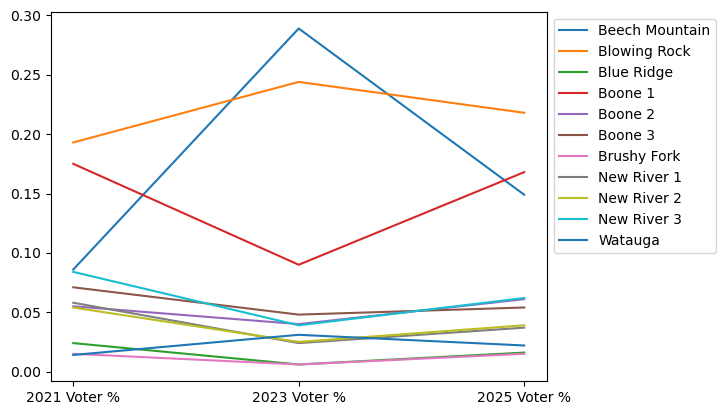

In [15]:
plt.plot(turnout_df.T)

plt.legend(bbox_to_anchor=(1, 1.0),  labels = ['Beech Mountain', 'Blowing Rock', 'Blue Ridge', 'Boone 1', 'Boone 2',
       'Boone 3', 'Brushy Fork', 'New River 1', 'New River 2', 'New River 3', 'Watauga'])

## DEM's who did NOT vote trend
- Breakdown of registered DEM voters who voted per precinct over '21, '23, and '25 election cycles.

In [16]:
def dem_turnout(vr, vhist):
    
    # Total dem pop 
    vr_dem_pop = vr[vr['party_cd'] == 'DEM'].groupby('Precincts')['voter_reg_num'].count()   
    vhist_pop = vhist[vhist['party_cd'] == 'DEM'].groupby('Precincts')['total_voters'].sum() 
    
    df = round(vhist_pop / vr_dem_pop, 3)

    return df


In [17]:
dem_21 = dem_turnout(vr_11_21, vhist_11_21)
dem_23 = dem_turnout(vr_11_23, vhist_11_23)
dem_25 = dem_turnout(vr_11_25, vhist_11_25)

turnout = {'2021 Voter %': dem_21, 
              '2023 Voter %': dem_23, 
              '2025 Voter %': dem_25}


dem_turnout_df = pd.DataFrame(turnout)
dem_turnout_df

,2021 Voter %,2023 Voter %,2025 Voter %
Precincts,,,
Beech Mountain,0.103,0.270,0.125
Blowing Rock,0.231,0.272,0.271
Blue Ridge,0.039,0.017,0.036
Boone 1,0.263,0.156,0.244
Boone 2,0.084,0.067,0.094
Boone 3,0.102,0.073,0.071
Brushy Fork,0.023,0.009,0.027
New River 1,0.082,0.043,0.072
New River 2,0.079,0.045,0.074


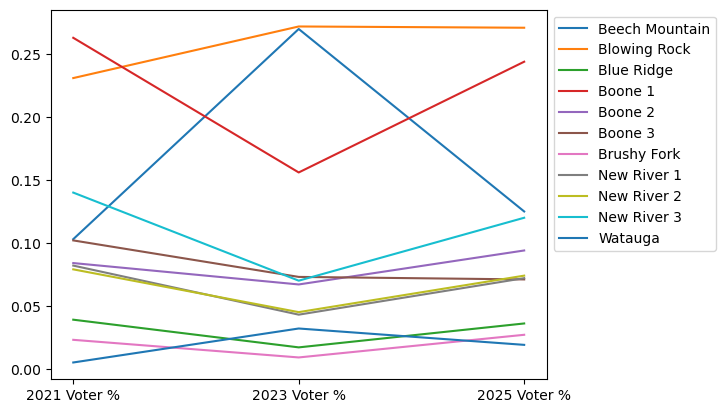

In [18]:
plt.plot(dem_turnout_df.T)

plt.legend(bbox_to_anchor=(1, 1.0),  labels = ['Beech Mountain', 'Blowing Rock', 'Blue Ridge', 'Boone 1', 'Boone 2',
       'Boone 3', 'Brushy Fork', 'New River 1', 'New River 2', 'New River 3', 'Watauga'])

## New VR's in Watauga versus other NC counties
- Watauga made up X% of the new VR's in 2021, Y% in 2023, and Z% in 2025. Given that our new VR count has trended up/downward over that period, this is good/bad.

In [19]:
# https://www.wataugacounty.org/App_Pages/Dept/BOE/precincts.aspx#2
# Added time frame constraint (8/1 to 10/31)

def vr_import_clean(df, cols):
    file = f'{df}'
    
    # Import file into python
    df = pd.read_csv(
    file,
    usecols = cols,
    delimiter = "\t",        
    encoding = "utf-16",  
    )
    
    # Filter data to just eligible voters
    df['status_cd'] = df['status_cd'].str.strip()

    df = df[(df['status_cd'] == 'A') | (df['status_cd'] == 'I') | (df['status_cd'] == 'S')]

    # Remove troublesome data rows and set the 'registr_dt' column as the index
    df = df[df['registr_dt'] != '##/##/####']
    df['registr_dt'] = pd.to_datetime(df['registr_dt'], errors='coerce')
    df = df.set_index('registr_dt')
    
    # Sort data from oldest VR's to newest
    df = df.sort_index(ascending=True)
    
    df = df.loc[f'{file[-12:-8]}-08-01':f'{file[-12:-8]}-10-31']

    return df
    

In [20]:
# VR columns and dataset

vr_11_25 = 'VR_Snapshot_20251104.txt'
vr_11_23 = 'VR_Snapshot_20231107.txt'
vr_11_21 = 'VR_Snapshot_20211102.txt'

vr_cols = ['registr_dt', 'precinct_abbrv', 'age', 'race_code', 'party_cd', 'sex_code', 'status_cd', 'voter_reg_num', 'county_desc']


In [21]:
# Include time frame (8/1 to 10/31) with the function.

vr_11_25 = vr_import_clean(vr_11_25, vr_cols)
vr_11_23 = vr_import_clean(vr_11_23, vr_cols)
vr_11_21 = vr_import_clean(vr_11_21, vr_cols)


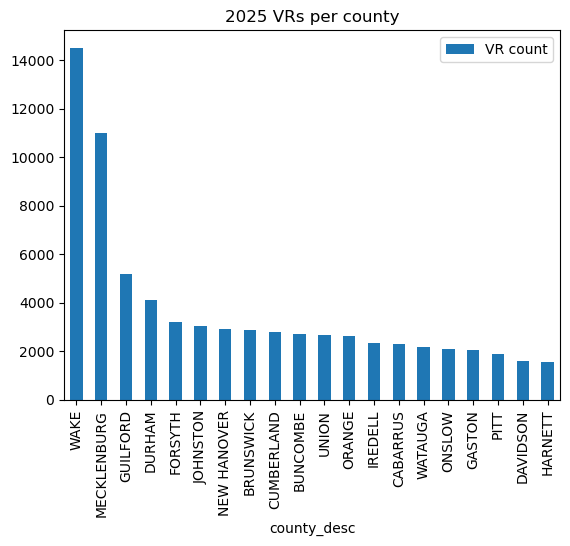

In [22]:
fig, ax = plt.subplots()

nc_county_df = pd.DataFrame(vr_11_21.groupby('county_desc')['voter_reg_num'].count())
nc_county_df = nc_county_df.sort_values(by = 'voter_reg_num', ascending = False)
top_20 = nc_county_df.head(20)
top_20.plot.bar(title='2025 VRs per county', ax = ax)
ax.legend(['VR count'])

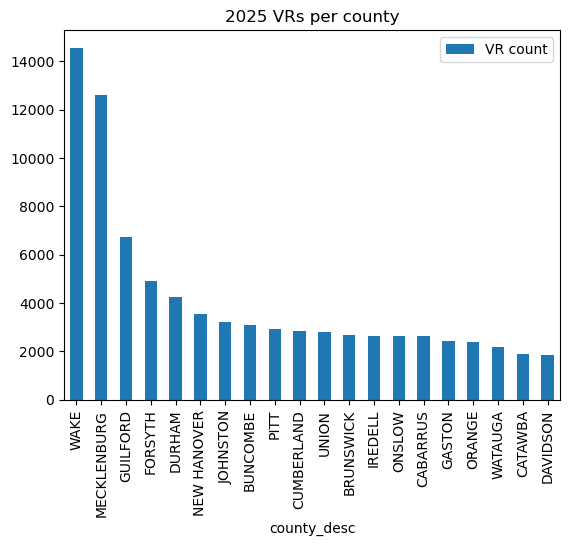

In [23]:
fig, ax = plt.subplots()

nc_county_df = pd.DataFrame(vr_11_23.groupby('county_desc')['voter_reg_num'].count())
nc_county_df = nc_county_df.sort_values(by = 'voter_reg_num', ascending = False)
top_20 = nc_county_df.head(20)
top_20.plot.bar(title='2025 VRs per county', ax = ax)
ax.legend(['VR count'])

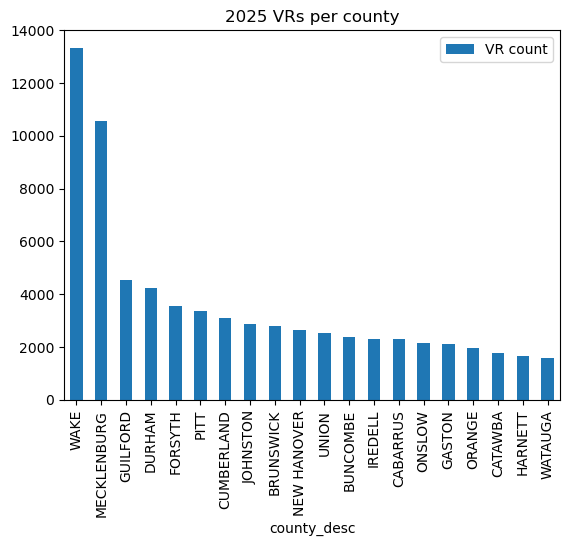

In [24]:
fig, ax = plt.subplots()

nc_county_df = pd.DataFrame(vr_11_25.groupby('county_desc')['voter_reg_num'].count())
nc_county_df = nc_county_df.sort_values(by = 'voter_reg_num', ascending = False)
top_20 = nc_county_df.head(20)
top_20.plot.bar(title='2025 VRs per county', ax = ax)
ax.legend(['VR count'])

In [25]:
print(round(vr_11_21[vr_11_21['county_desc'] == 'WATAUGA']['age'].count() / len(vr_11_21), 4))
print(round(vr_11_23[vr_11_23['county_desc'] == 'WATAUGA']['age'].count() / len(vr_11_23), 4))
print(round(vr_11_25[vr_11_25['county_desc'] == 'WATAUGA']['age'].count() / len(vr_11_25), 4))

0.0196
0.0178
0.0148


In [26]:
def pie_chart(df1, df2, df3, col):

    fig, axes = plt.subplots(2, 2, figsize = (8, 5))
    
    df1[f'{col}'].value_counts().plot.pie(ax = axes[0, 0], autopct='%1.1f%%', colors = ['cornflowerblue', 'LightBlue', 'Grey'])
    df2[f'{col}'].value_counts().plot.pie(ax = axes[0, 1], autopct='%1.1f%%', colors = ['cornflowerblue', 'LightBlue', 'Grey'])
    df3[f'{col}'].value_counts().plot.pie(ax = axes[1, 0], autopct='%1.1f%%', colors = ['cornflowerblue', 'LightBlue', 'Grey'])

    fig.delaxes(axes[1][1])
        

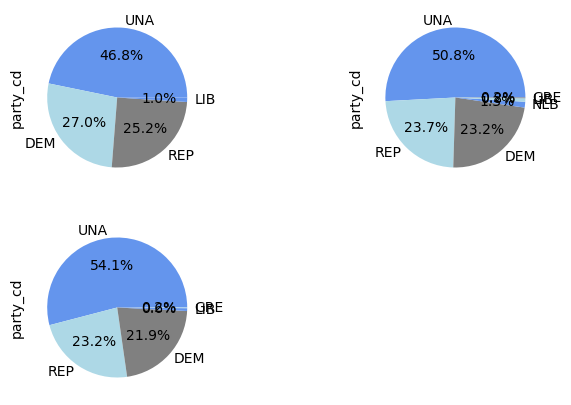

In [27]:
pie_chart(vr_11_21, vr_11_23, vr_11_25, 'party_cd')

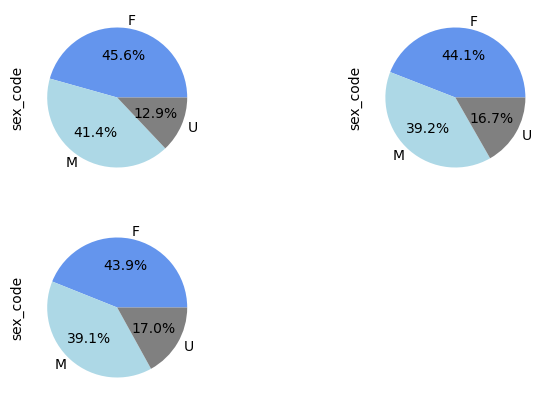

In [28]:
pie_chart(vr_11_21, vr_11_23, vr_11_25, 'sex_code')

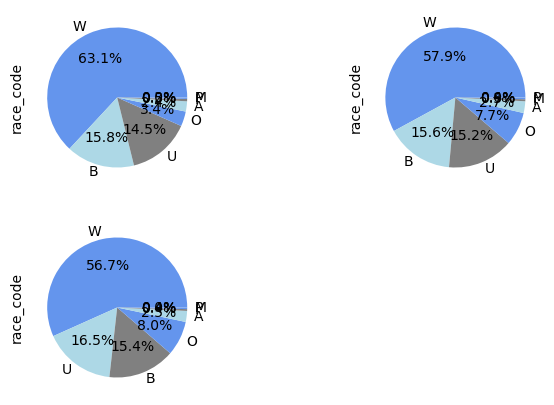

In [29]:
pie_chart(vr_11_21, vr_11_23, vr_11_25, 'race_code')